In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["local"]
store_status_coll = db["store_status"]
timezone_coll = db["restaurant_tz"]
menu_hours_coll = db["menu_hours"]
reports_coll = db["reports"]

In [ ]:
from datetime import datetime
import pytz

def get_unique_store_ids_from_poll() -> list[str]:
    """
    Returns a list of unique store IDs from the "store_id" field in the store_status_coll collection.

    Returns:
        list[str]: A list of unique store IDs.
    """
    return store_status_coll.distinct("store_id")

def get_timezone_using_store_id(store_id: str) -> str:
    """
    Returns the timezone string for the given store ID from the timezone_coll collection,
    or "America/Chicago" if the store ID is not found.

    Args:
        store_id (str): The store ID to retrieve the timezone for.

    Returns:
        str: The timezone string for the given store ID, or "America/Chicago" if the store ID is not found.
    """
    result = timezone_coll.find_one({"store_id": store_id})
    return result["timezone_str"] if result else "America/Chicago"

def utc_to_local(utc_time_str: str, timezone_str: str) -> str:
    """
    Converts a UTC datetime string to a local datetime string in the specified timezone.

    Args:
        utc_time_str (str): A UTC datetime string in the format "%Y-%m-%d %H:%M:%S.%f UTC".
        timezone_str (str): A timezone string in the format "America/Chicago".

    Returns:
        str: A local datetime string in the format "%Y-%m-%d %H:%M:%S.%f".
    """
    utc_time = datetime.strptime(utc_time_str, "%Y-%m-%d %H:%M:%S.%f UTC")
    local_tz = pytz.timezone(timezone_str)
    local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_time.strftime("%Y-%m-%d %H:%M:%S.%f")

In [ ]:
from pymongo import ASCENDING

def get_poll_data_of_store(store_id: str):
    """
    Fetches poll data for a given store ID and returns it as a dictionary of lists,
    where each key represents a day of the week and each value is a list of poll
    data for that day.

    Args:
        store_id (str): The ID of the store to fetch poll data for.

    Returns:
        dict: A dictionary of lists, where each key represents a day of the week
        (0 for Monday, 6 for Sunday) and each value is a list of poll data for that day.
        Each poll data item is represented as a dictionary with the keys "timestamp_local"
        (a string representing the local time in the format "HH:MM:SS") and "status"
        (a boolean representing the status of the store at that time).
    """
    tz: str = get_timezone_using_store_id(store_id)

    result = store_status_coll.find(
        {"store_id": store_id},
        projection={"_id": False, "timestamp_utc": True, "status": True},
    )
    result.sort([("timestamp_utc", ASCENDING)])
    data = {"0": [], "1": [], "2": [], "3": [], "4": [], "5": [], "6": []}
    for doc in result:
        if (
            datetime.strptime(doc["timestamp_utc"], "%Y-%m-%d %H:%M:%S.%f UTC")
            > datetime.now()
        ):
            continue
        local_time = utc_to_local(doc["timestamp_utc"], tz)
        data[
            str(datetime.strptime(local_time, "%Y-%m-%d %H:%M:%S.%f").weekday())
        ].append(
            {
                "timestamp_local": datetime.strptime(
                    local_time, "%Y-%m-%d %H:%M:%S.%f"
                ).strftime("%H:%M:%S"),
                "status": 1 if doc["status"] == "active" else 0,
            }
        )
    return data

In [ ]:
def filter_status_by_business_hours(day_status: list[dict], day_business_hours: list[dict]) -> list[dict]:
    """
    Filters the list of status entries for a particular day based on the business hours.

    Args:
        day_status (list[dict]): A list of status entries for the day, each containing the timestamp_local and status keys.
        day_business_hours (list[dict]): A list of business hours for the day, each containing the start_time_local and end_time_local keys.

    Returns:
        list[dict]: A list of status entries that fall within the business hours.
    """
    filtered_status = []
    for entry in day_status:
        timestamp = datetime.strptime(entry["timestamp_local"], "%H:%M:%S").time()
        for hours in day_business_hours:
            start_time = datetime.strptime(hours["start_time_local"], "%H:%M:%S").time()
            end_time = datetime.strptime(hours["end_time_local"], "%H:%M:%S").time()
            if start_time <= timestamp <= end_time:
                filtered_status.append(entry)
                break
    return filtered_status

In [ ]:
import pandas as pd
def downsampled_data(data):
    """
    Downsamples time-series data to hourly intervals.

    Args:
        data: A list of dictionaries representing time-series data. Each dictionary
            should have the keys "timestamp_local" (a string representing a local
            timestamp in the format "HH:MM:SS") and "status" (a float representing a
            status value).

    Returns:
        A list of dictionaries representing the downsampled time-series data. Each
        dictionary has the keys "timestamp_local" (a string representing a local
        timestamp in the format "HH:MM:SS") and "status" (a string representing the
        mean status value for the corresponding hourly interval).
    """

    df = pd.DataFrame(data)
    if not data:
        return df

    df["timestamp_local"] = pd.to_datetime(df["timestamp_local"])
    df.set_index("timestamp_local", inplace=True)
    downsampled = df.resample("60T").mean()
    downsampled_data = [
        {"timestamp_local": ts.time().strftime("%H:%M:%S"), "status": status}
        for ts, status in zip(downsampled.index, downsampled["status"])
    ]
    return downsampled_data

In [ ]:
def get_business_hours_of_store(store_id: str)-> dict[str, list[dict[str, str]]]:
    """
    Returns a dictionary of the business hours for each day of the week for a given store.

    Args:
        store_id (str): the ID of the store

    Returns:
        Dict[str, List[Dict[str, str]]]: a dictionary where each key represents a day of the week
        (0-6 for Monday to Sunday) and each value is a list of dictionaries containing the start and end times
        for each business hour period on that day in the format {"start_time_local": "HH:MM:SS", "end_time_local": "HH:MM:SS"}.
    """
    business_hours = {"0": [], "1": [], "2": [], "3": [], "4": [], "5": [], "6": []}

    for rec in menu_hours_coll.find({"store_id": store_id}):
        business_hours[rec["day"]].append(
                {
                    "start_time_local": rec["start_time_local"],
                    "end_time_local": rec["end_time_local"],
                }
            )

        # TODO: Can also interpolate the business hours of a particular day using the polling data.
    for day, hours in business_hours.items():
        if not hours:
            business_hours[day] = [
                    {
                        "start_time_local": "00:00:00",
                        "end_time_local": "23:59:59",
                    }
                ]
            
    return business_hours

In [ ]:
def get_store_poll_data_per_day(store_poll_data, business_hours) -> dict[str, list]:
    """
    Given a dictionary of store poll data and a dictionary of business hours, returns a dictionary
    of downsampled and filtered store poll data, with one key-value pair for each day of the week.

    Parameters:
    - store_poll_data (dict): A dictionary of store poll data, with keys 0-6 representing days of the week,
    and values being lists of dictionaries with keys "timestamp_local" (a string representing the local timestamp)
    and "status" (a string representing the store's status).
    - business_hours (dict): A dictionary of business hours, with keys 0-6 representing days of the week,
    and values being lists of dictionaries with keys "start_time_local" (a string representing the local start time)
    and "end_time_local" (a string representing the local end time).

    Returns:
    - store_poll_data_per_day (dict): A dictionary of downsampled and filtered store poll data, with keys 0-6
    representing days of the week, and values being lists of dictionaries with keys "timestamp_local"
    (a string representing the local timestamp) and "status" (a string representing the store's status), 
    [0.0, 1.0] in factor of hours,
    """

    store_poll_data_per_day = {
        "0": [],
        "1": [],
        "2": [],
        "3": [],
        "4": [],
        "5": [],
        "6": [],
    }
    for day in range(0, 7):
        store_poll_data_per_day[str(day)] = filter_status_by_business_hours(
            store_poll_data[str(day)], business_hours[str(day)]
        )
        store_poll_data_per_day[str(day)] = sorted(
            store_poll_data_per_day[str(day)], key=lambda x: x["timestamp_local"]
        )
        store_poll_data_per_day[str(day)] = downsampled_data(
            store_poll_data_per_day[str(day)]
        )

    return store_poll_data_per_day

In [ ]:
from datetime import timedelta
import math

def uptime_today(store_poll_data_per_day) -> tuple(float, float):
    """
    Calculates the uptime for the current day and the minutes of uptime for the last hour.

    Args:
    - store_poll_data_per_day: a dictionary containing the polling data for each day of the week.

    Returns:
    A tuple containing two floats:
    - hours_today: the number of hours of uptime for the current day.
    - minutes_last_hour: the number of minutes of uptime for the last hour.
    """

    last_weekday: int = datetime.now().weekday() - 1
    last_hour: str = (datetime.now() - timedelta(hours=1)).strftime("%H:00:00")

    hours_today: float = 0.0
    minutes_last_hour: float = 0.0

    for day_data in store_poll_data_per_day[str(last_weekday)]:
        hours_today += day_data["status"] if not math.isnan(day_data["status"]) else 0

        if day_data["timestamp_local"] == last_hour:
            minutes_last_hour = float(
                day_data["status"] * 60 if not math.isnan(day_data["status"]) else 0
            )

    return hours_today, minutes_last_hour


def uptime_hours_this_week(store_poll_data_per_day) -> float:
    """
    Calculates the total uptime hours for the current week based on the data in store_poll_data_per_day.

    Args:
    - store_poll_data_per_day: a dictionary containing the store poll data for each day of the week

    Returns:
    - hours_this_week: a float representing the total uptime hours for the current week
    """
    hours_this_week: float = 0.0
    for weekday in range(0, 7):
        for day_data in store_poll_data_per_day[str(weekday)]:
            hours_this_week += (
                day_data["status"] if not math.isnan(day_data["status"]) else 0
            )

    return hours_this_week

In [ ]:
from typing import Any

def generate_report() -> list:
    """
    Generates a report for all stores based on their uptime/downtime statistics for the last hour, day, and week.

    Returns:
    A list of dictionaries, where each dictionary contains the following keys:
    - 'store_id': (str) The ID of the store.
    - 'uptime_last_hour': (float) The uptime of the store in minutes for the last hour.
    - 'downtime_last_hour': (float) The downtime of the store in minutes for the last hour.
    - 'uptime_last_day': (float) The uptime of the store in hours for the last day.
    - 'downtime_last_day': (float) The downtime of the store in hours for the last day.
    - 'uptime_last_week': (float) The uptime of the store in hours for the last week.
    - 'downtime_last_week': (float) The downtime of the store in hours for the last week.
    """
    result: list = []

    for store_id in get_unique_store_ids_from_poll():
        current_result: dict[str, Any] = {
            "store_id": store_id,
            "uptime_last_hour": 0.0,
            "downtime_last_hour": 60.0,
            "uptime_last_day": 0.0,
            "downtime_last_day": 24.0,
            "uptime_last_week": 0.0,
            "downtime_last_week": 168.0,
        }

        # [{'timestamp_local:"", 'status':""}]
        store_poll_data: dict[str, list] = get_poll_data_of_store(store_id)

        # {'day':[{'start_time_local':"", 'start_time_local':""}]}
        business_hours: dict[str, list] = get_business_hours_of_store(store_id)

        store_poll_data_per_day: dict[str, list] = get_store_poll_data_per_day(
            store_poll_data, business_hours
        )

        (hours_today, minutes_last_hour) = uptime_today(store_poll_data_per_day)

        hours_this_week: float = uptime_hours_this_week(store_poll_data_per_day)

        current_result["uptime_last_hour"] = minutes_last_hour
        current_result["uptime_last_day"] = hours_today
        current_result["uptime_last_week"] = hours_this_week
        current_result["downtime_last_hour"] = 60 - current_result["uptime_last_hour"]
        current_result["downtime_last_day"] = 24 - current_result["uptime_last_day"]
        current_result["downtime_last_week"] = 168 - current_result["uptime_last_week"]
        result.append(current_result)

    return result

* Profiling data

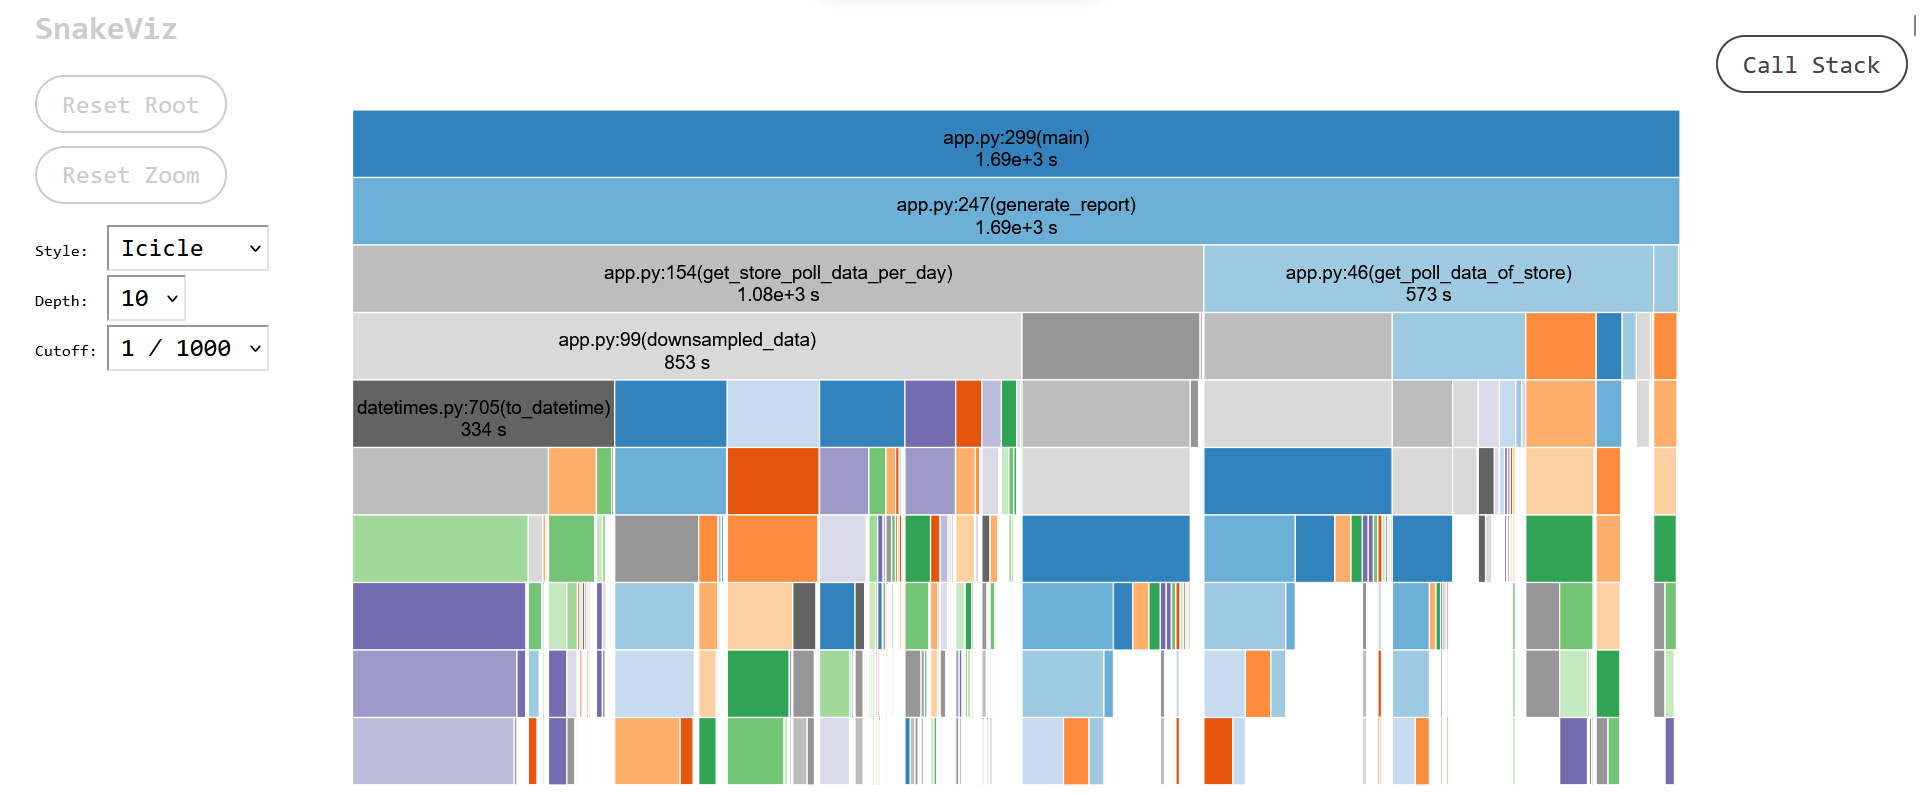

* API endpoints

In [ ]:
from fastapi import FastAPI

app: FastAPI = FastAPI()

In [ ]:
import uuid

from fastapi.responses import JSONResponse

@app.get("/trigger-report")
def trigger_report() -> JSONResponse:
    running_doc: Any | None = reports_coll.find_one(
        {"sentinel_id": 0, "status": "running"}
    )
    if running_doc:
        response_body: dict[str, str] = {
            "message": "Running",
            "report_id": running_doc["report_id"],
        }
        return JSONResponse(content=response_body, status_code=400)

    # Report generation
    report_id: str = str(uuid.uuid4())
    reports_coll.update_one(
        {"sentinel_id": 0, "status": "complete"},
        {
            "$set": {"status": "running", "report_id": report_id},
        },
    )

    report: list = generate_report()
    reports_coll.insert_one(
        {"report_id": report_id, "report": report, "report_status": "complete"}
    )
    response_body: dict[str, str] = {
        "message": "Complete",
        "report_id": report_id,
    }

    reports_coll.update_one({"sentinel_id": 0}, {"$set": {"status": "complete"}})

    return JSONResponse(content=response_body, status_code=200)

# endpoint: 

# GET http://127.0.0.1:8000/trigger-report

In [ ]:
from pydantic import BaseModel

from fastapi import Response


class ReportRequest(BaseModel):
    report_id: str

@app.post("/get-report")
def get_report(report_request: ReportRequest, response: Response) -> JSONResponse:
    running_doc: Any | None = reports_coll.find_one(
        {"sentinel_id": 0, "status": "running"}
    )

    completed_report: Any | None = reports_coll.find_one(
        {"report_id": report_request.report_id, "report_status": "complete"}
    )

    if running_doc:
        return JSONResponse(
            content={"message": "Running", "report_id": running_doc["report_id"]},
            status_code=400,
        )

    if completed_report:
        cursor = reports_coll.find({"report_id": report_request.report_id})

        data: list = list(cursor)
        data = pd.DataFrame(data[0]["report"])
        csv_data: str = data.to_csv(index=False)
        response.headers["Content-Disposition"] = "attachment; filename=data.csv"
        response.headers["Content-Type"] = "text/csv"
        return JSONResponse(content=csv_data, status_code=200)

    return JSONResponse(content={"message": "invalid report id"}, status_code=404)

# endpoint

# POST http://127.0.0.1:8000/get-report/
# Content-Type: application/json
# {
#     "report_id":"222002b6-5465-45e1-b58b-38587a5155ab"
# }

### Scope of improvement

- Using exponential average algorithm instead of direct downsampling the data to favour the recent polling.
- Using asynchronous functions or multithreading to return the response "running" quickly when calling /trigger-report instead of waiting for 7-10 minutes for the report to get generated and return the status.  